# Import


In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter, gmtime, strftime
from functions import remove_high_corr, scale_variables, best_params_grid,\
    calculate_confusion_matrix, plot_roc_auc_curve, bart_auc_scorer, make_label,get_error_and_auc

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RepeatedKFold, train_test_split,\
    cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,\
    make_scorer, balanced_accuracy_score, f1_score, matthews_corrcoef

# Load data

In [2]:
data = pd.read_csv('/home/gustavo/github/mestrado/reworks/models/oral_vs_non_oral/data/fda_heuristics_preprocessed.csv')
data.head()

,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,...,NumRings,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeterocycles,NumAromaticHeterocycles,NumAliphaticHeterocycles,NumBridgeheadAtoms,NumAtomStereoCenters,CrippenClogP
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.16143
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.48830
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.95610
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.12510
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.00530


# Separating X and Y matrices, and test and train

In [3]:
Y = data['natural_product_flag']
Y = Y.astype(float)
Y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: natural_product_flag, dtype: float64

In [4]:
Y.sum() # we have 519 natural products, highly imbalanced data

519.0

In [5]:
X = data.iloc[:,14:]
X.head()

,exactmw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumAmideBonds,FractionCSP3,NumRings,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeterocycles,NumAromaticHeterocycles,NumAliphaticHeterocycles,NumBridgeheadAtoms,NumAtomStereoCenters,CrippenClogP
0,59.048347,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.16143
1,75.032028,3.0,2.0,0.0,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.48830
2,76.027277,4.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.95610
3,77.029920,1.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.12510
4,78.013936,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.00530


In [6]:
np.random.seed(6752)
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)

# Scaling datasets

In [7]:
# Train
x_train_scaled = scale_variables(x_train)
# Adding a constant to represent the intercept
x_train_scaled = sm.add_constant(x_train_scaled)
x_train_scaled.head()

,const,exactmw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumAmideBonds,FractionCSP3,NumRings,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeterocycles,NumAromaticHeterocycles,NumAliphaticHeterocycles,NumBridgeheadAtoms,NumAtomStereoCenters,CrippenClogP
0,1.0,1.612176,0.225109,-0.929855,2.879532,0.344139,0.635140,0.543384,0.300554,0.360539,0.008794,0.496879,-0.686401,1.132139,-0.230475,-0.668076,2.577526
1,1.0,-0.508300,-1.002364,-0.509720,-0.072563,-0.522921,-0.636245,-0.616869,0.300554,-0.918678,-0.772179,-1.029747,-0.686401,-0.762760,-0.230475,-0.382132,0.370573
2,1.0,-0.342520,-0.511375,-0.509720,-0.072563,-0.522921,-1.108099,-0.616869,0.300554,-0.918678,-0.772179,-1.029747,-0.686401,-0.762760,-0.230475,-0.668076,0.492929
3,1.0,0.660965,0.470603,-0.089585,0.349165,0.344139,-0.847765,1.123510,1.912207,-0.279069,0.008794,1.260191,1.837211,0.184689,-0.230475,-0.668076,0.826180
4,1.0,-0.038744,0.470603,-0.089585,-0.072563,-0.522921,-0.760417,-0.036743,1.106381,-0.918678,-0.772179,0.496879,1.837211,-0.762760,-0.230475,-0.668076,-0.079966


In [8]:
# Test
x_test_scaled = scale_variables(x_test)
x_test_scaled = sm.add_constant(x_test_scaled)
print(x_test_scaled.shape)
x_test_scaled.head()

(474, 17)


,const,exactmw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumAmideBonds,FractionCSP3,NumRings,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeterocycles,NumAromaticHeterocycles,NumAliphaticHeterocycles,NumBridgeheadAtoms,NumAtomStereoCenters,CrippenClogP
0,1.0,0.032403,0.262530,-0.084618,-0.581759,1.337395,0.044396,0.584287,1.199942,-0.259779,0.014663,2.012469,3.261012,0.171856,-0.209684,-0.096415,0.098017
1,1.0,-0.800081,-0.502466,-0.493894,-0.079932,-0.532591,0.323728,-0.574509,-0.487810,-0.259779,0.014663,-0.223258,-0.639038,0.171856,-0.209684,-0.371721,-0.605857
2,1.0,0.236119,0.517529,-0.084618,-0.079932,-0.532591,-1.331101,1.163685,2.887694,-0.888020,-0.757577,1.267227,3.261012,-0.723305,-0.209684,-0.371721,0.507360
3,1.0,-0.038052,0.517529,-0.493894,-0.581759,-0.532591,-1.459095,0.004889,0.356066,-0.259779,-0.757577,-0.968501,-0.639038,-0.723305,-0.209684,-0.647026,-0.335847
4,1.0,0.347031,0.007532,-0.084618,-0.581759,-0.532591,1.022834,0.584287,-1.331686,1.624943,1.559143,-0.968501,-0.639038,-0.723305,-0.209684,1.555418,-0.115457


In [9]:
# Dataframe to store final results from every model
final_results = pd.DataFrame(
    columns=[
        "model_name",
        'cv_test_auc',
        'training_mis_rate',
        'test_mis_rate',
        'training_auc',
        'test_auc',
        'balanced_acc_test',
        'mcc_train',
        'mcc_tets'
    ]
)

# Logit

## CV

In [10]:
model_params_lr = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=500),
        'params': {}
    }
}

In [11]:
gs_results_lr, gs_results_lr_full = best_params_grid(x_train_scaled, y_train, model_params_lr)
gs_results_lr

Starting Grid Search for Logistic Regression: 18:15
Finished Grid Search for Logistic Regression: 18:15
Tempo de execução:  0.0 minutos


,model,best_score,best_params
0,Logistic Regression,0.952552,{}


## Fitting logitstic

In [12]:
lr_params = gs_results_lr.iloc[0,2]
print(lr_params)
logistic = LogisticRegression(**lr_params, max_iter=500).fit(x_train_scaled, y_train)

{}


## Get Training Error and AUC


In [13]:
mis_rate_lr_train, auc_lr_train = get_error_and_auc(
    model=logistic,
    x=x_train_scaled,
    y_true=y_train
)

Training Misclassification Rate: 0.0753
Training AUC: 0.8913


## Predictions


In [14]:
y_predict_lr_label = logistic.predict(x_test_scaled)
y_predict_lr_prob = logistic.predict_proba(x_test_scaled)[:,1]

## Test error and ROC


In [15]:
mis_rate_lr, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_lr_label
)

Misclassification rate: 0.0928


Text(0.5, 1.0, 'CM: Logit\n Natural vs Synthetic')

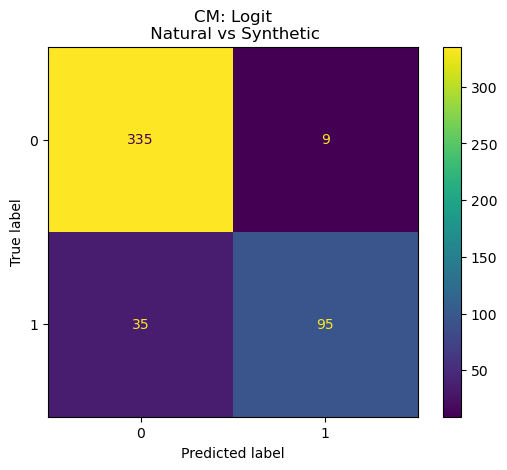

In [16]:
disp.plot()
plt.title(f"CM: Logit\n Natural vs Synthetic")

## AUC ROC


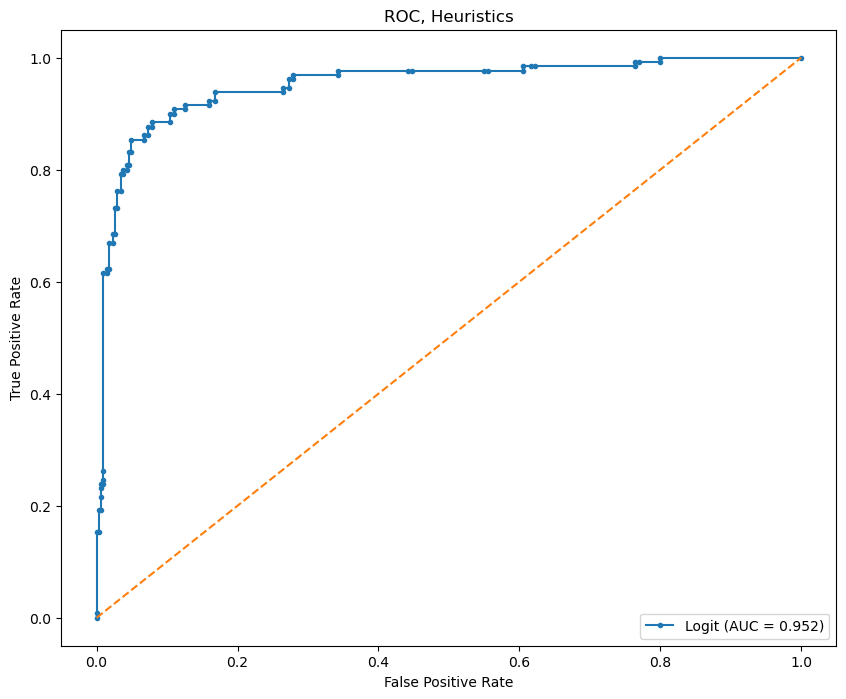

In [17]:
auc_lr = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_lr_prob,
    model_name='Logit',
    title=f'ROC, Heuristics',
    save_path=f'/home/gustavo/github/mestrado/reworks/imgs/logit_heuristics_total.png'
)

## Feature Importance

In [18]:
pd.DataFrame({'coef': logistic.coef_[0], 'name': x_train_scaled.columns.to_list()})

,coef,name
0,-0.000046,const
1,0.262297,exactmw
2,0.864998,lipinskiHBA
3,0.197703,lipinskiHBD
4,-0.563009,NumRotatableBonds
5,-0.455431,NumAmideBonds
6,-0.394053,FractionCSP3
7,0.079218,NumRings
8,-1.584897,NumAromaticRings
9,1.345320,NumAliphaticRings


## Results

In [19]:
balanced_acc_test_lr = balanced_accuracy_score(y_test, y_predict_lr_label)
mcc_test_lr = matthews_corrcoef(y_test, y_predict_lr_label)
mcc_train_lr = matthews_corrcoef(y_train, logistic.predict(x_train_scaled))
print(f"Balanced acc test set: {balanced_acc_test_lr}\
      MCC train set for logit: {mcc_train_lr}, MCC test set for logit: {mcc_test_lr}")

Balanced acc test set: 0.8523032200357781      MCC train set for logit: 0.8068057536935461, MCC test set for logit: 0.7595912862917545


In [20]:
final_results.loc[len(final_results.index)] = [
    'Logistic Regression',
    gs_results_lr['best_score'][0],
    mis_rate_lr_train,
    mis_rate_lr,
    auc_lr_train,
    auc_lr,
    balanced_acc_test_lr,
    mcc_train_lr,
    mcc_test_lr
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc,balanced_acc_test,mcc_train,mcc_tets
0,Logistic Regression,0.952552,0.075299,0.092827,0.891298,0.951856,0.852303,0.806806,0.759591


# Decision Tree

In [21]:
dt_model_params = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy'],
            'max_depth':[2,4,8,12],
            'ccp_alpha':[0,0.000001,0.00001,0.0001, 0.0003, 0.001, 0.01]
        }
    }
}

In [22]:
gs_results_dt, gs_results_dt_full = best_params_grid(x_train_scaled, y_train, dt_model_params)
gs_results_dt

Starting Grid Search for Decision Tree: 18:15
Finished Grid Search for Decision Tree: 18:15
Tempo de execução:  0.1 minutos


,model,best_score,best_params
0,Decision Tree,0.922895,"{'ccp_alpha': 0.01, 'criterion': 'entropy', 'm..."


## Fitting tree

In [23]:
decision_tree_params = gs_results_dt.iloc[0,2]
print(decision_tree_params)
decision_tree = DecisionTreeClassifier(**decision_tree_params).fit(x_train_scaled, y_train)

{'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': 8}


## Training Error and AUC

In [24]:
mis_rate_dt_train, auc_dt_train = get_error_and_auc(
    model=decision_tree,
    x=x_train_scaled,
    y_true=y_train
)

Training Misclassification Rate: 0.0767
Training AUC: 0.8887


## Test Prediction

In [25]:
y_predict_dt_label = decision_tree.predict(x_test_scaled)
y_predict_dt_prob = decision_tree.predict_proba(x_test_scaled)[:,1]

## Test errors

In [26]:
mis_rate_dt, disp= calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_dt_label
)

Misclassification rate: 0.0865


Text(0.5, 1.0, 'CM Decision Tree Test Set\n Natural vs Non Natural')

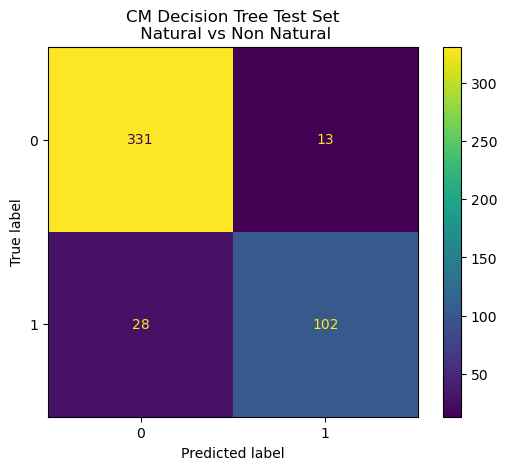

In [27]:
disp.plot()
plt.title(f"CM Decision Tree Test Set\n Natural vs Non Natural")

## ROC for Test Set

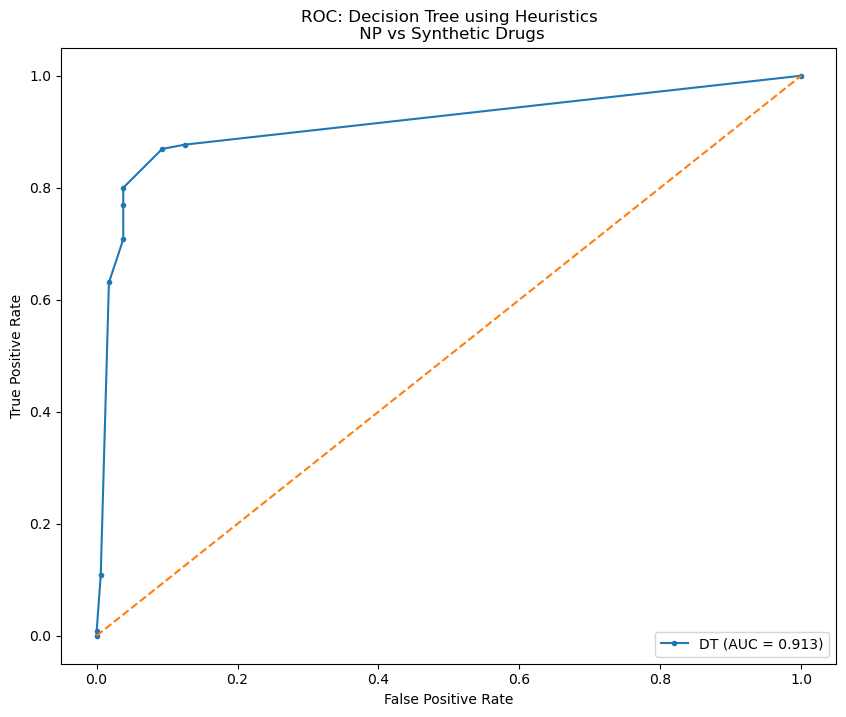

In [28]:
auc_dt = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_dt_prob,
    model_name='DT',
    title=f"ROC: Decision Tree using Heuristics\n NP vs Synthetic Drugs",
    save_path=f"/home/gustavo/github/mestrado/reworks/imgs/dt_heuristics_natural_testset.png"
)

## Feature Importance

Text(0.5, 1.0, 'Feature Importance: Decision Tree \n NP vs Synthetic Drugs')

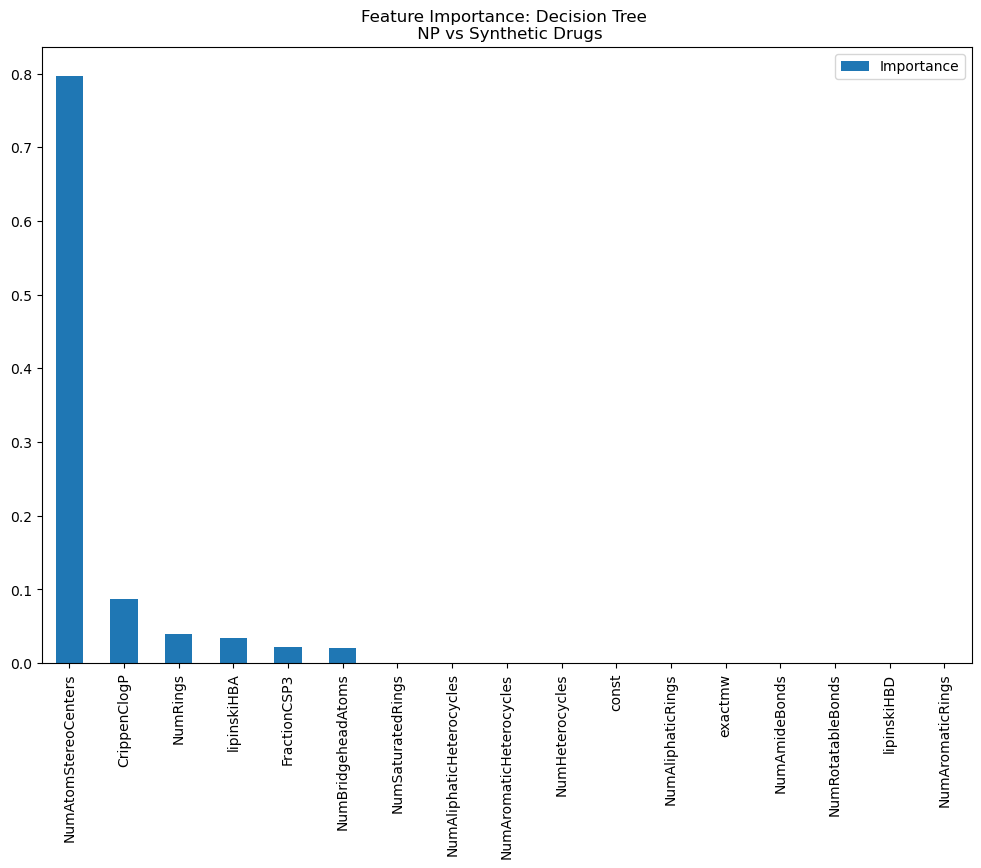

In [29]:
# print the feature importances
fig, ax = plt.subplots(1,1)
feat_importances = pd.DataFrame(
    decision_tree.feature_importances_,
    index=x_train_scaled.columns,
    columns=['Importance']
)
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.iloc[:30,:].plot(kind='bar', figsize=(12,8), ax=ax)
ax.set_title(f"Feature Importance: Decision Tree \n NP vs Synthetic Drugs")

In [30]:
important_features_dt = feat_importances[feat_importances.Importance > 0].sort_values(by='Importance',
                                                                                      ascending=False)
important_features_dt[0:30]

,Importance
NumAtomStereoCenters,0.796077
CrippenClogP,0.087019
NumRings,0.039946
lipinskiHBA,0.034444
FractionCSP3,0.022579
NumBridgeheadAtoms,0.019935


## Results


In [31]:
balanced_acc_test_dt = balanced_accuracy_score(y_test, y_predict_dt_label)
mcc_train_dt = matthews_corrcoef(y_train, decision_tree.predict(x_train_scaled))
mcc_test_dt = matthews_corrcoef(y_test, y_predict_dt_label)

print(f"Balanced ACC test set: {balanced_acc_test_dt}\
      MCC train {mcc_train_dt} e MCC test {mcc_test_dt}")

final_results.loc[len(final_results.index)] = [
    'Decision Tree',
    gs_results_dt['best_score'][0],
    mis_rate_dt_train,
    mis_rate_dt,
    auc_dt_train,
    auc_dt,
    balanced_acc_test_dt,
    mcc_train_dt,
    mcc_test_dt
]

final_results

Balanced ACC test set: 0.873412343470483      MCC train 0.8030268508691586 e MCC test 0.7772727074070548


,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc,balanced_acc_test,mcc_train,mcc_tets
0,Logistic Regression,0.952552,0.075299,0.092827,0.891298,0.951856,0.852303,0.806806,0.759591
1,Decision Tree,0.922895,0.076707,0.086498,0.888728,0.913417,0.873412,0.803027,0.777273


# Random Forest and Bagging

In [32]:
# Hyperparameter finetuning
rf_model_params = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'max_depth': [5,6,7,10],
            'max_features': ['sqrt', x_train.shape[0]],
            'ccp_alpha':[0, 0.0001, 0.01],
            'min_samples_split':[4, 7]
        }
    }
}

In [33]:
gs_results_rf, gs_results_rf_full = best_params_grid(x_train_scaled, y_train, rf_model_params)
gs_results_rf

Starting Grid Search for Random Forest: 18:15
Finished Grid Search for Random Forest: 18:18
Tempo de execução:  2.5 minutos


,model,best_score,best_params
0,Random Forest,0.970873,"{'ccp_alpha': 0.0001, 'max_depth': 10, 'max_fe..."


## Fitting Model


In [34]:
random_forest_params = gs_results_rf.iloc[0,2]
print(random_forest_params)
random_forest = RandomForestClassifier(**random_forest_params).fit(x_train_scaled, y_train)

{'ccp_alpha': 0.0001, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 4}


## Making test predictions


In [35]:
y_predict_rf_label = random_forest.predict(x_test_scaled)
y_predict_rf_prob = random_forest.predict_proba(x_test_scaled)[:,1]

## Get Training Error and Training AUC

In [36]:
mis_rate_rf_train, auc_rf_train=get_error_and_auc(
    model=random_forest,
    x=x_train_scaled,
    y_true=y_train
)

Training Misclassification Rate: 0.0099
Training AUC: 0.9820


## Test error

In [37]:
mis_rate_rf, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_rf_label
)

Misclassification rate: 0.0570


Text(0.5, 1.0, 'CM: Random Forest \n NP vs Synthetic Heutistics')

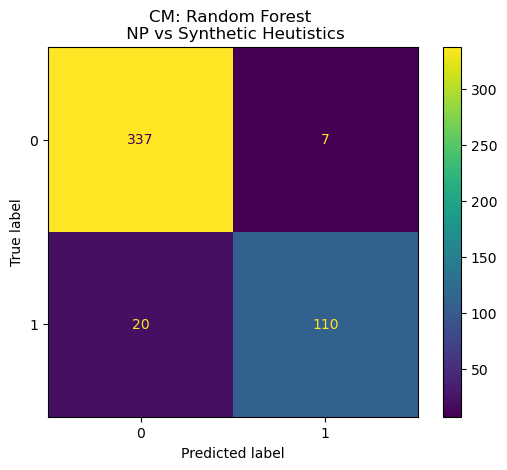

In [38]:
disp.plot()
plt.title(f"CM: Random Forest \n NP vs Synthetic Heutistics")

## ROC/AUC

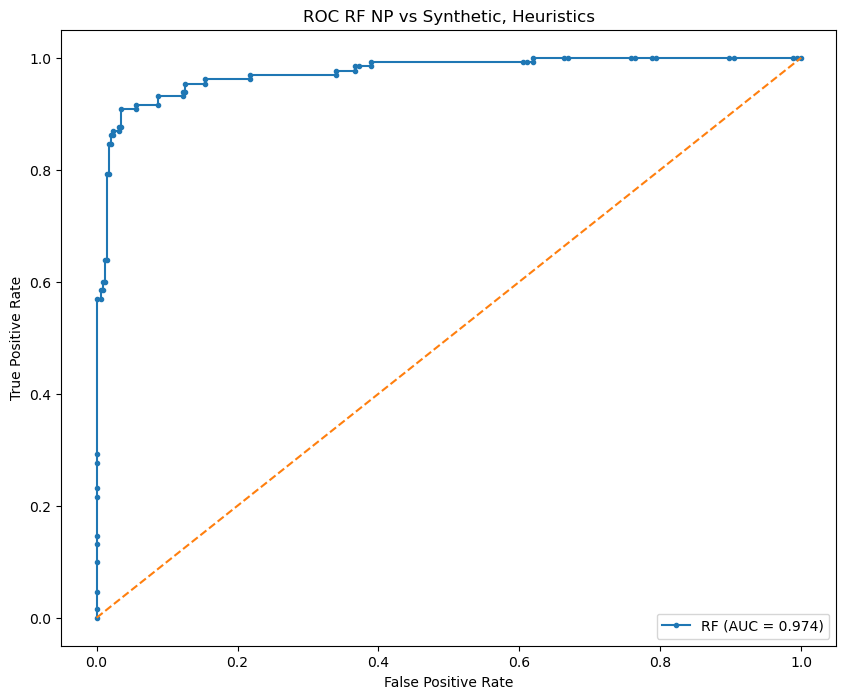

In [39]:
auc_rf = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_rf_prob,
    model_name='RF',
    title=f"ROC RF NP vs Synthetic, Heuristics",
    save_path=f'/home/gustavo/github/mestrado/reworks/imgs/roc_auc_heuristics_rf_np.png'
)

## Feature Importance

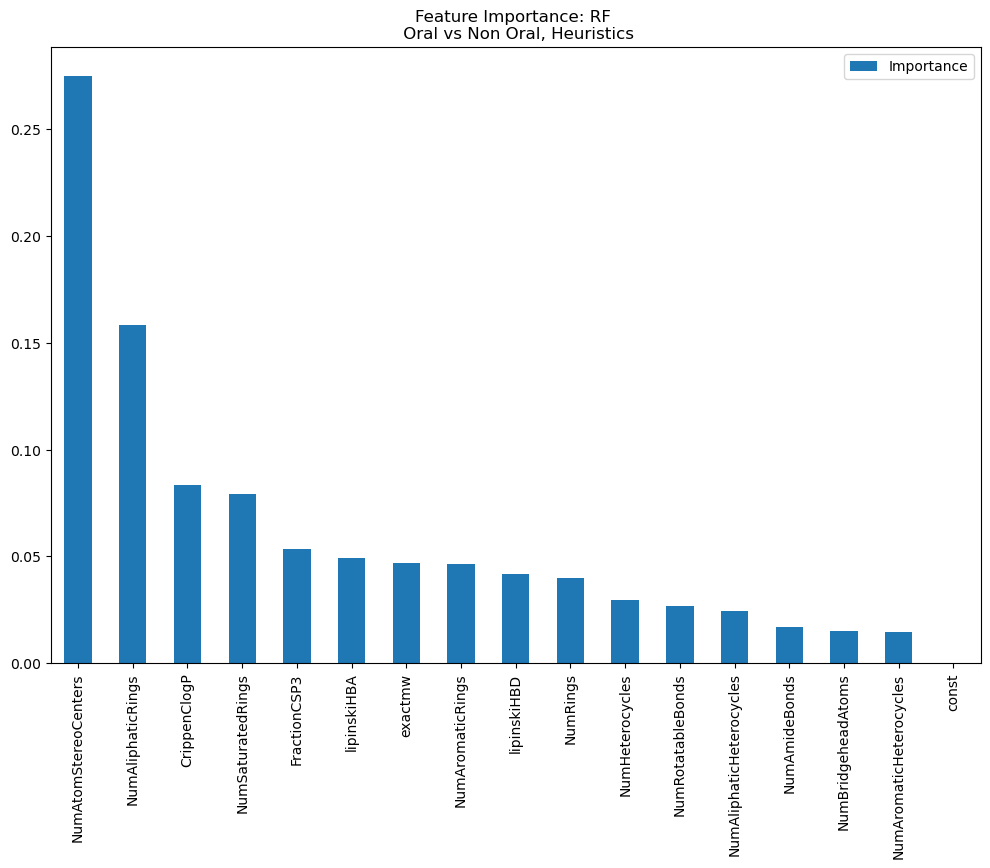

In [40]:
fig, ax = plt.subplots(1,1)
feat_importances = pd.DataFrame(random_forest.feature_importances_,
                                index=x_train_scaled.columns,
                                columns=['Importance'])

feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.iloc[:30,:].plot(kind='bar', figsize=(12,8), ax=ax)
ax.set_title(f"Feature Importance: RF \n Oral vs Non Oral, Heuristics")
fig.savefig(f"/home/gustavo/github/mestrado/reworks/imgs/feature_importance_rf_heuristics_np.png")

In [41]:
important_features_rf = feat_importances[feat_importances.Importance > 0].sort_values(by='Importance', ascending=False)
important_features_rf[0:30]

,Importance
NumAtomStereoCenters,0.274779
NumAliphaticRings,0.158178
CrippenClogP,0.083296
NumSaturatedRings,0.079022
FractionCSP3,0.053353
lipinskiHBA,0.049017
exactmw,0.046789
NumAromaticRings,0.046288
lipinskiHBD,0.041774
NumRings,0.040030


## Saving Results

In [42]:
balanced_acc_test_rf = balanced_accuracy_score(y_test, y_predict_rf_label)
mcc_train_rf = matthews_corrcoef(y_train, random_forest.predict(x_train_scaled))
mcc_test_rf = matthews_corrcoef(y_test, y_predict_rf_label)


print(f"Balanced ACC test set random forest: {balanced_acc_test_rf}\
      MCC train set: {mcc_train_rf}, MCC test set {mcc_test_rf}")

final_results.loc[len(final_results.index)] = [
    'Random Forest',
    gs_results_rf['best_score'][0],
    mis_rate_rf_train,
    mis_rate_rf,
    auc_rf_train,
    auc_rf,
    balanced_acc_test_rf,
    mcc_train_rf,
    mcc_test_rf
]

final_results

Balanced ACC test set random forest: 0.9129025044722718      MCC train set: 0.9752474862765411, MCC test set 0.8544789556928801


,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc,balanced_acc_test,mcc_train,mcc_tets
0,Logistic Regression,0.952552,0.075299,0.092827,0.891298,0.951856,0.852303,0.806806,0.759591
1,Decision Tree,0.922895,0.076707,0.086498,0.888728,0.913417,0.873412,0.803027,0.777273
2,Random Forest,0.970873,0.009852,0.056962,0.982005,0.973658,0.912903,0.975247,0.854479


# Gradient Boosting

In [43]:
boosting_model_params = {
    'Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'learning_rate':[0.04, 0.05],
            'max_depth': [5,8,10],
            'min_samples_split':[16,18],
            'subsample':[0.6,0.8]
        }
    }
}

In [44]:
gs_results_boost, gs_result_boost_full = best_params_grid(x_train_scaled, y_train, boosting_model_params)
gs_results_boost

Starting Grid Search for Boosting: 18:18
Finished Grid Search for Boosting: 18:20
Tempo de execução:  2.0 minutos


,model,best_score,best_params
0,Boosting,0.967695,"{'learning_rate': 0.04, 'max_depth': 10, 'min_..."


## Fitting the Model

In [45]:
boosting_params = gs_results_boost.iloc[0,2]
print(boosting_params)
boosting = GradientBoostingClassifier(**boosting_params).fit(x_train_scaled, y_train)

{'learning_rate': 0.04, 'max_depth': 10, 'min_samples_split': 18, 'subsample': 0.6}


## Get training error and AUC

In [46]:
mis_rate_boost_train, auc_boost_train = get_error_and_auc(
    model=boosting,
    x=x_train_scaled,
    y_true=y_train
)

Training Misclassification Rate: 0.0084
Training AUC: 0.9862


## Make predictions

In [47]:
y_predict_boost_label = boosting.predict(x_test_scaled)
y_predict_boost_prob = boosting.predict_proba(x_test_scaled)[:,1]

## Test Error

Misclassification rate: 0.0527


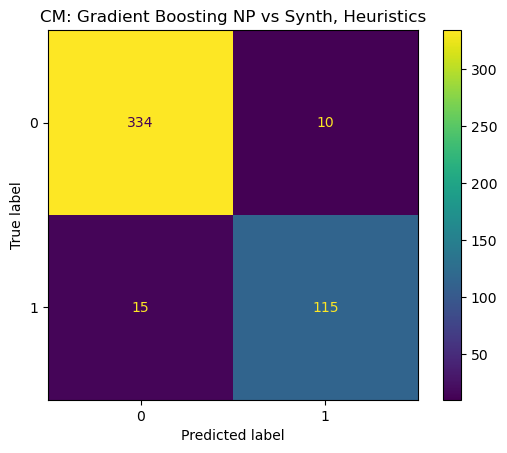

In [48]:
mis_rate_boost, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_boost_label
)
disp.plot()
plt.title(f"CM: Gradient Boosting NP vs Synth, Heuristics")
plt.show()

## ROC/AUC Test

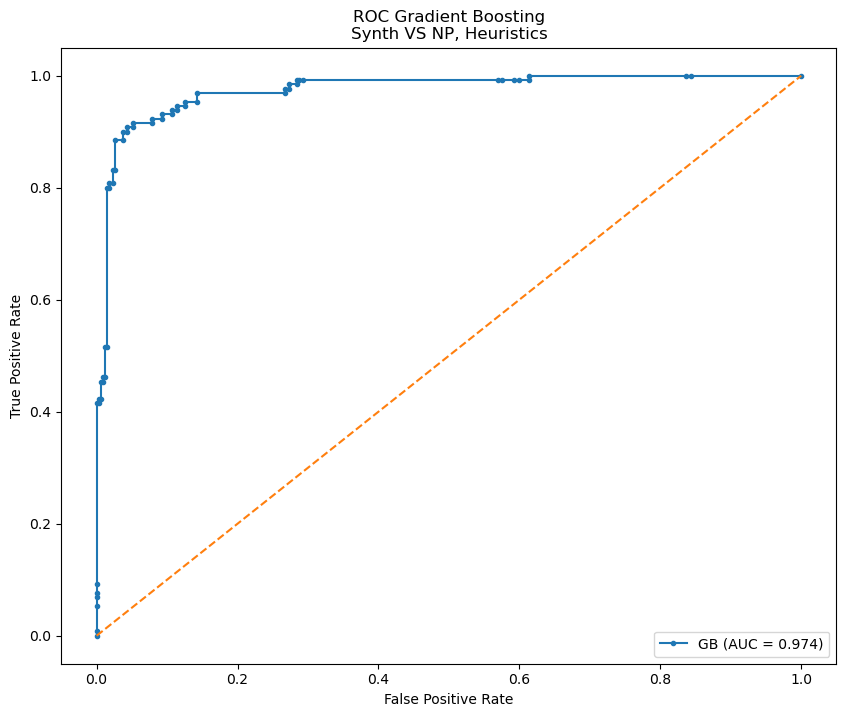

In [49]:
auc_boost = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_boost_prob,
    model_name='GB',
    title=f"ROC Gradient Boosting\nSynth VS NP, Heuristics",
    save_path=f'/home/gustavo/github/mestrado/reworks/imgs/roc_auc_np_heuristics_testset_gb.png'
)

## Feature Importance

Text(0.5, 1.0, 'Feature Importance: Gradient Boosting\n NP vs Synth, Heuristics')

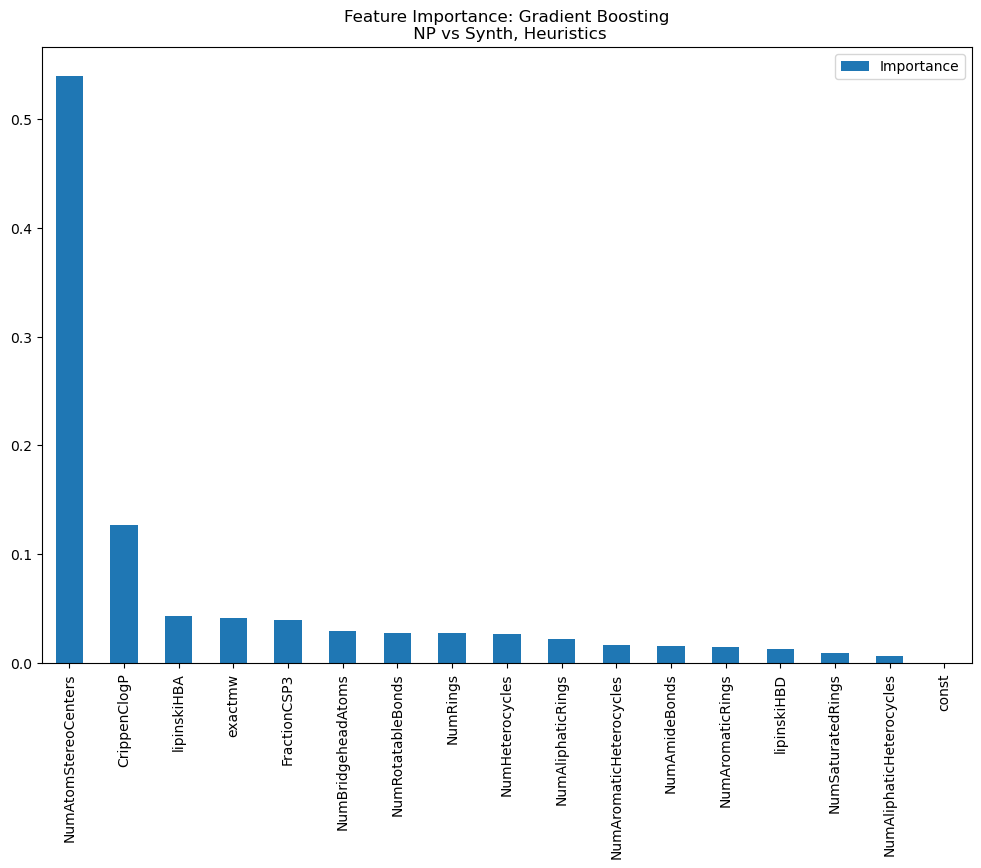

In [50]:
fig, ax = plt.subplots(1,1)
feat_importances = pd.DataFrame(boosting.feature_importances_,
                                index=x_train_scaled.columns, columns=['Importance'])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(12,8), ax=ax)
ax.set_title(f"Feature Importance: Gradient Boosting\n NP vs Synth, Heuristics")

In [51]:
important_features_boost = feat_importances[feat_importances.Importance > 0].sort_values(
    by='Importance', ascending=False)
important_features_boost[0:30]

,Importance
NumAtomStereoCenters,0.538837
CrippenClogP,0.126635
lipinskiHBA,0.043072
exactmw,0.041669
FractionCSP3,0.039805
NumBridgeheadAtoms,0.029918
NumRotatableBonds,0.027476
NumRings,0.027474
NumHeterocycles,0.026327
NumAliphaticRings,0.022466


## Saving Results

In [52]:
balanced_acc_test_boost=balanced_accuracy_score(y_test, y_predict_boost_label)
mcc_train_boost = matthews_corrcoef(y_train, boosting.predict(x_train_scaled))
mcc_test_boost = matthews_corrcoef(y_test, y_predict_boost_label)

print(f"Balanced ACC test set {balanced_acc_test_boost},\
        MCC test set {mcc_test_boost} MCC train set {mcc_train_boost}")

final_results.loc[len(final_results.index)] = [
    'Gradient Boosting',
    gs_results_boost['best_score'][0],
    mis_rate_boost_train,
    mis_rate_boost,
    auc_boost_train,
    auc_boost,
    balanced_acc_test_boost,
    mcc_train_boost,
    mcc_test_boost
]
final_results

Balanced ACC test set 0.927772808586762,        MCC test set 0.866216292967251 MCC train set 0.9787243128128629


,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc,balanced_acc_test,mcc_train,mcc_tets
0,Logistic Regression,0.952552,0.075299,0.092827,0.891298,0.951856,0.852303,0.806806,0.759591
1,Decision Tree,0.922895,0.076707,0.086498,0.888728,0.913417,0.873412,0.803027,0.777273
2,Random Forest,0.970873,0.009852,0.056962,0.982005,0.973658,0.912903,0.975247,0.854479
3,Gradient Boosting,0.967695,0.008445,0.052743,0.986178,0.974329,0.927773,0.978724,0.866216


# SVM

## Hyperparameter Fine Tuning

In [53]:
svm_model_params = {
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.01, 0.1, 0.2, 1, 2, 4],
            'kernel': ['rbf', 'sigmoid'],
            'gamma':['auto', 0.0001, 0.001]
        }
    }
}

In [54]:
gs_results_svm, gs_results_svm_full = best_params_grid(x_train_scaled, y_train, svm_model_params)

Starting Grid Search for SVM: 18:20
Finished Grid Search for SVM: 18:20
Tempo de execução:  0.5 minutos


In [55]:
gs_results_svm

,model,best_score,best_params
0,SVM,0.971759,"{'C': 4, 'gamma': 'auto', 'kernel': 'rbf'}"


## Fitting the model

In [56]:
svm_params = gs_results_svm.iloc[0,2]
print(svm_params)
svm = SVC(**svm_params, probability=True).fit(x_train_scaled, y_train)

{'C': 4, 'gamma': 'auto', 'kernel': 'rbf'}


## Get Training Error and AUC

In [57]:
miss_rate_svm_train, auc_svm_train = get_error_and_auc(
    model=svm, x=x_train_scaled,y_true=y_train
)

Training Misclassification Rate: 0.0281
Training AUC: 0.9622


## Make Prediction

In [58]:
y_predict_svm_label = svm.predict(x_test_scaled)
y_predict_svm_prob = svm.predict_proba(x_test_scaled)[:,1]

## Test Error

Misclassification rate: 0.0612


Text(0.5, 1.0, 'Confusion Matrix SVM\n NP vs Synth')

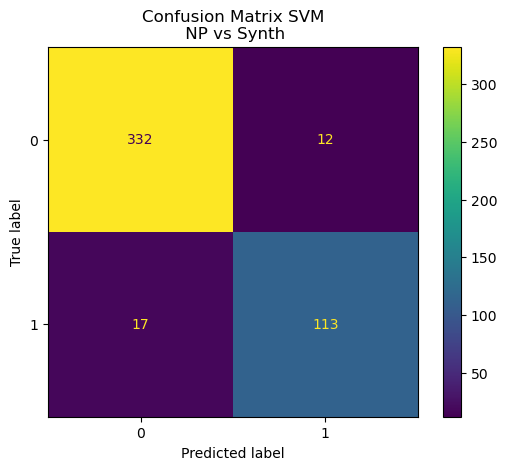

In [59]:
mis_rate_svm, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_svm_label
)

disp.plot()
plt.title(f"Confusion Matrix SVM\n NP vs Synth")

## ROC

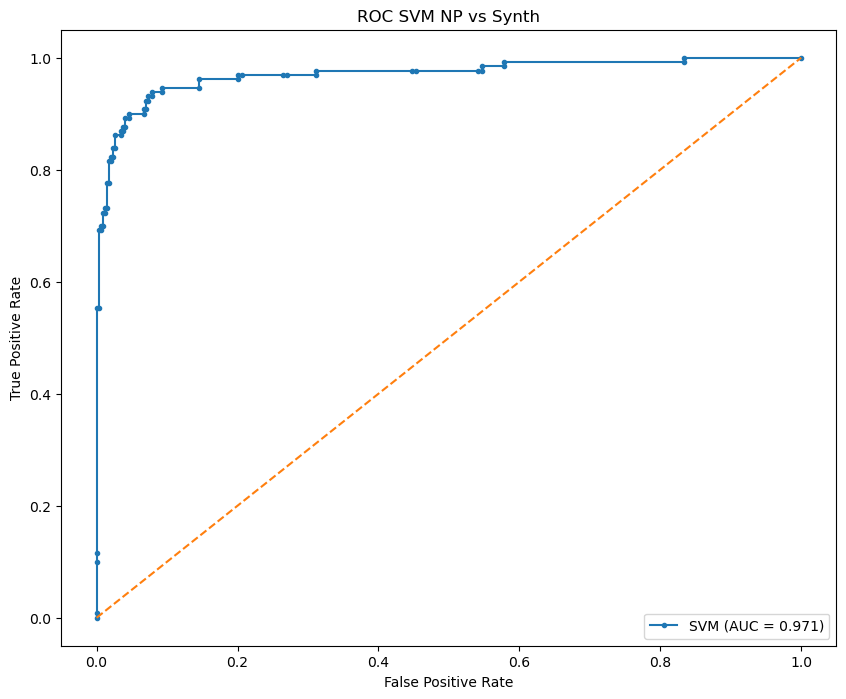

In [60]:
auc_svm = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_svm_prob,
    model_name='SVM',
    title=f'ROC SVM NP vs Synth',
    save_path=f'/home/gustavo/github/mestrado/reworks/imgs/roc_auc_heuristics_svm_np_synth.png'
)

## Saving Results

In [61]:
balanced_acc_test_svm = balanced_accuracy_score(y_test, y_predict_svm_label)
mcc_train_svm = matthews_corrcoef(y_train, svm.predict(x_train_scaled))
mcc_test_svm = matthews_corrcoef(y_test, y_predict_svm_label)

print(f"Balanced ACC Test {balanced_acc_test_svm}\
      MCC train: {mcc_train_svm} MCC test: {mcc_test_svm}")


final_results.loc[len(final_results.index)] = [
    'SVM',
    gs_results_svm['best_score'][0],
    miss_rate_svm_train,
    mis_rate_svm,
    auc_svm_train,
    auc_svm,    
    balanced_acc_test_svm,
    mcc_train_svm,
    mcc_test_svm
]

final_results

Balanced ACC Test 0.9171735241502683      MCC train: 0.928917342408175 MCC test: 0.8447533278409323


,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc,balanced_acc_test,mcc_train,mcc_tets
0,Logistic Regression,0.952552,0.075299,0.092827,0.891298,0.951856,0.852303,0.806806,0.759591
1,Decision Tree,0.922895,0.076707,0.086498,0.888728,0.913417,0.873412,0.803027,0.777273
2,Random Forest,0.970873,0.009852,0.056962,0.982005,0.973658,0.912903,0.975247,0.854479
3,Gradient Boosting,0.967695,0.008445,0.052743,0.986178,0.974329,0.927773,0.978724,0.866216
4,SVM,0.971759,0.028149,0.061181,0.962201,0.970550,0.917174,0.928917,0.844753
